In [1]:
import glob
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import concatenate_images, imread, imread_collection, imshow
from skimage.transform import resize
from matplotlib import patches

from config import Config
from mrcnn_data_api import Mrcnn_Data_API
from mrcnn_api import Mrcnn_API
import utils
import model as modellib

/home/w/anaconda3/envs/idp3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class GISSConfig(Config):

    NAME = "giss_depth0"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 6

    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    IMAGE_CHANNELS = 3
    IMAGE_PADDING = True

    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 128
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)
    RPN_NMS_THRESHOLD = 0.7
    DETECTION_MAX_INSTANCES = 128
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.3
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0001
    USE_RPN_ROIS = True
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])
    STEPS_PER_EPOCH = 26
    VALIDATION_STEPS = 7

    
class InferenceConfig(GISSConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


class GISSDataset(utils.Dataset):

    def load_data(self, X, y, ids, shapes, classes, src):

        self.add_class("giss", 1, "car")
        self.add_class("giss", 2, "building")
        self.add_class("giss", 3, "human")
        self.add_class("giss", 4, "truck")
        self.add_class("giss", 5, "container")
        self.add_class("giss", 6, "winter-car")
        
        for i in range(len(ids)):
            img_path = src + ids[i]
            self.add_image("giss", image_id=ids[i], path=img_path,
                           image=X[i], mask=y[i], classes=classes[i],
                           shape=shapes[i])
        
    def load_image(self, image_id):
        info = self.image_info[image_id]
        return info['image']

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        class_ids = np.asarray(info['classes'])
        return info['mask'], class_ids.astype(np.int32)

## Data API:


### configuration:

In [3]:
set_filename = '2018-01-18_resized_deg90_100m_part1'  # Set containing depth maps for subset of images.
# set_filename = '2018-01-18_resized_deg0_part2_zlomowisko'  # Set without depth maps.
mode = 'train'


src_basic = '/home/w/Projects/PW-GISS/data/data/giss_images/resized/'
src_depth_basic = '/home/w/Projects/PW-GISS/data/data/detector-depth/'
src_y = '/home/w/Projects/PW-GISS/data/models/labels/2018-03-01_resized_degX_combined/\
train_2018-03_01_resized_degX_combined.csv'


giss_data_config = {
    'src': src_basic,  # Directory containing folders with sets of images.
    'set_filename': set_filename,  # Name of subset directory, which will be used.
    'src_images': '{}{}/'.format(src_basic, set_filename),  # Directory from which RGB images are loaded, should be combination of src_basic and set_filename.
    'src_depth': '{}{}/'.format(src_depth_basic, set_filename),  # Directory from which depth maps are loaded, should be combination of src_basic and set_filename.
    'dst': '{}{}/'.format(src_basic, set_filename),  # Directory, to which processed masks are saved as .pkl files.
    'y': pd.read_csv(src_y),  # Dataframe consisting of bounding boxes for objects in images.
    'dataset_config': GISSDataset,  # Dataset configuration for MRCNN training.
    'image_filetype': 'JPG',  # Image filetype, for which data API looks, set to '*' to look for all types.
    'image_shape': (1024, 1024),  # Maximum shape of image used for model training. Images are resized and padded to this size.
    'save': True,  # Whether to save .pkl files after processing of images and creation of masks.
    'add_depth_map': False,  # Whether to add depth maps for chosen set of images. Set intersection of RGB and depth maps is used for training in such case.
    'mode': mode,  # Mode, should be 'train' or 'test'. With 'train' training and validation datasets are created.
    'valid_split_size': 0.2,  # Fraction of dataset size to be used for validation.
}


api_data = Mrcnn_Data_API(
    image_shape=giss_data_config['image_shape'],
    resize_and_pad=True,  # Whether to resize and pad images to specified image_shape.
    verbose=True)  # Whether to show progress of files processing.

### Masks creation from bounding boxes coordinates:

### Masks creation and saving (can be used instead of above function):

In [4]:
# Create masks from bbox labels file, process the data into model-suitable form and save processed files into pickles:

api_data.process_raw_images(
    giss_data_config['src_images'],
    giss_data_config['y'],
    image_filetype=giss_data_config['image_filetype'],
    save=giss_data_config['save'],
    dst=giss_data_config['dst'],
    set_filename=giss_data_config['set_filename'],
    mode=giss_data_config['mode'])

  0%|          | 0/39 [00:00<?, ?it/s]/home/w/anaconda3/envs/idp3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Processing raw images into masks.

Creating masks from: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/
Selecting JPG images.
Maximum resized image shape: (1024, 1024)


Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0018.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 31)
Image min: 2, max: 255


  3%|▎         | 1/39 [00:01<01:00,  1.60s/it]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0020.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0021.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 40)
Image min: 0, max: 255


  8%|▊         | 3/39 [00:03<00:43,  1.20s/it]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0023.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 53)
Image min: 0, max: 255


 10%|█         | 4/39 [00:06<00:53,  1.53s/it]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0024.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0026.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0028.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 19)
Image min: 0, max: 255


 18%|█▊        | 7/39 [00:07<00:32,  1.02s/it]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0029.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0031.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 15)
Image min: 0, max: 255


 23%|██▎       | 9/39 [00:07<00:26,  1.13it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0032.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0033.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 9)
Image min: 0, max: 254


 28%|██▊       | 11/39 [00:08<00:21,  1.29it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0034.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 10)
Image min: 0, max: 237


 31%|███       | 12/39 [00:09<00:20,  1.32it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0035.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 10)
Image min: 0, max: 251


 33%|███▎      | 13/39 [00:09<00:19,  1.34it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0036.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 8)
Image min: 2, max: 255


 36%|███▌      | 14/39 [00:10<00:18,  1.37it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0037.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0038.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 22)
Image min: 0, max: 255


 41%|████      | 16/39 [00:11<00:16,  1.41it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0039.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 25)
Image min: 0, max: 255


 44%|████▎     | 17/39 [00:12<00:16,  1.35it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0041.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 16)
Image min: 0, max: 253


 46%|████▌     | 18/39 [00:13<00:15,  1.33it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0043.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 17)
Image min: 0, max: 239


 49%|████▊     | 19/39 [00:14<00:15,  1.31it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0045.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 12)
Image min: 0, max: 255


 51%|█████▏    | 20/39 [00:15<00:14,  1.32it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0046.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0047.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 8)
Image min: 0, max: 255


 56%|█████▋    | 22/39 [00:15<00:12,  1.40it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0049.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 22)
Image min: 0, max: 255


 59%|█████▉    | 23/39 [00:16<00:11,  1.36it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0051.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 18)
Image min: 0, max: 255


 62%|██████▏   | 24/39 [00:17<00:11,  1.35it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0053.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 15)
Image min: 0, max: 255


 64%|██████▍   | 25/39 [00:18<00:10,  1.34it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0054.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 10)
Image min: 0, max: 255


 67%|██████▋   | 26/39 [00:19<00:09,  1.35it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0056.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 10)
Image min: 0, max: 255


 69%|██████▉   | 27/39 [00:19<00:08,  1.36it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0057.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 13)
Image min: 0, max: 255


 72%|███████▏  | 28/39 [00:20<00:08,  1.36it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0058.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 14)
Image min: 0, max: 255


 74%|███████▍  | 29/39 [00:21<00:07,  1.35it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0059.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 13)
Image min: 0, max: 255


 77%|███████▋  | 30/39 [00:22<00:06,  1.35it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0060.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 10)
Image min: 0, max: 255


 79%|███████▉  | 31/39 [00:22<00:05,  1.36it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0061.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0062.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 14)
Image min: 0, max: 255


 85%|████████▍ | 33/39 [00:23<00:04,  1.40it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0065.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 15)
Image min: 0, max: 255


 87%|████████▋ | 34/39 [00:24<00:03,  1.40it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0067.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 12)
Image min: 0, max: 255


 90%|████████▉ | 35/39 [00:25<00:02,  1.40it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0073.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 15)
Image min: 0, max: 255


 92%|█████████▏| 36/39 [00:25<00:02,  1.39it/s]

Mask min: 0, max: 1

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0074.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0075.JPG
Image loading failed.

Processing image: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/DJI_0077.JPG
Original image shape: (975, 1300, 3)
Mask shape: (975, 1300, 14)
Image min: 0, max: 255


100%|██████████| 39/39 [00:26<00:00,  1.46it/s]

Mask min: 0, max: 1

Omitted images: 10

Saving pickle files into: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/



### Loading saved .pkl files:

In [5]:
# Load processed data:

X, masks, image_names, image_shapes, image_classes = api_data.load_data(
    src=giss_data_config['dst'],
    set_filename=giss_data_config['set_filename'],
    mode=giss_data_config['mode'])


Loading processed data files from: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/



### Create MRCNN datasets for training and prediction:


Preparing MRCNN datasets.
Validation split fraction: 0.2

Loading processed data files from: /home/w/Projects/PW-GISS/data/data/giss_images/resized/2018-01-18_resized_deg90_100m_part1/



  0%|          | 0/29 [00:00<?, ?it/s]


Padding resized images to: (1024, 1024)


100%|██████████| 29/29 [00:04<00:00,  5.82it/s]



Splitting on index: 23
Number of training images : 23
Number of validation images : 6



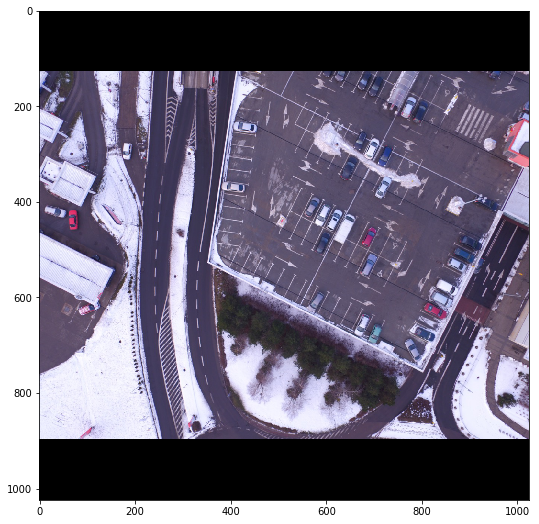

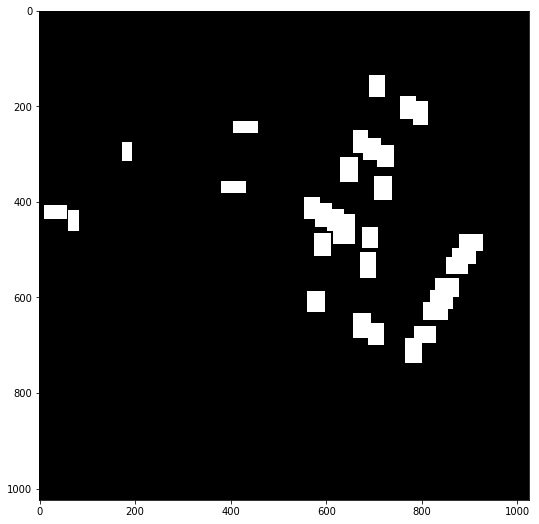

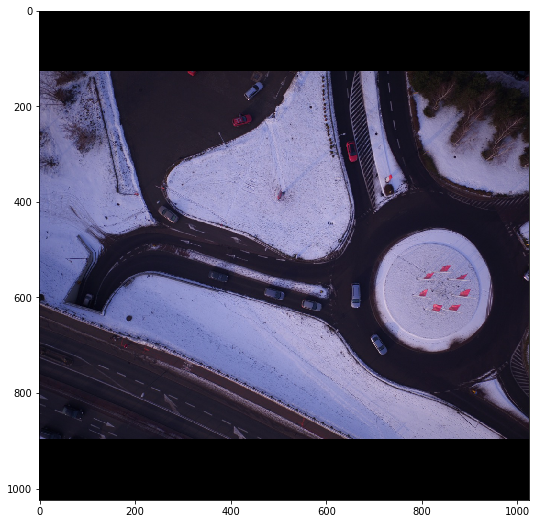

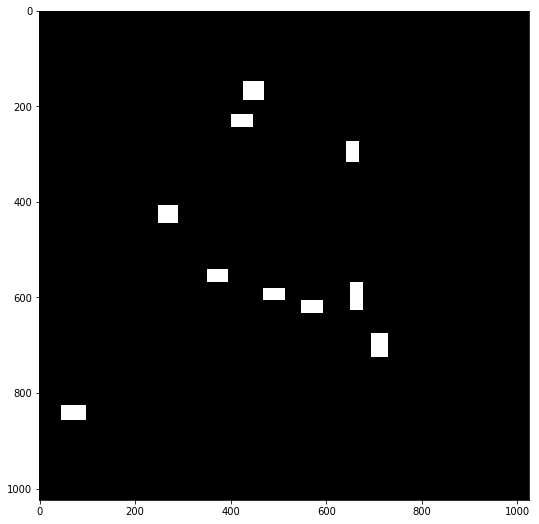

23 6


In [6]:
plt.rcParams['figure.figsize'] = (12, 9)


# Create MRCNN datasets from processed data:

if mode == 'train':
    dataset_train, dataset_val = api_data.prepare_data_for_training(
        src_data=giss_data_config['dst'],
        src_depth=giss_data_config['src_depth'],
        mode=giss_data_config['mode'],
        set_filename=giss_data_config['set_filename'],
        add_depth_map=giss_data_config['add_depth_map'],
        valid_split_size=giss_data_config['valid_split_size'],
        dataset_config=giss_data_config['dataset_config'])

    plt.imshow(dataset_train.image_info[0]['image'].astype(np.uint8))
    plt.show()
    plt.imshow(np.max(dataset_train.image_info[0]['mask'].astype(np.uint8), axis=-1), cmap='gray')
    plt.show()
    plt.imshow(dataset_val.image_info[0]['image'].astype(np.uint8))
    plt.show()
    plt.imshow(np.max(dataset_val.image_info[0]['mask'].astype(np.uint8), axis=-1), cmap='gray')
    plt.show()
    print(len(dataset_train.image_info), len(dataset_val.image_info))

if mode == 'test':
    dataset_test = api_data.prepare_data_for_training(
        src_data=giss_data_config['dst'],
        src_depth=giss_data_config['src_depth'],
        mode=giss_data_config['mode'],
        set_filename=giss_data_config['set_filename'],
        add_depth_map=giss_data_config['add_depth_map'],
        valid_split_size=giss_data_config['valid_split_size'],
        dataset_config=giss_data_config['dataset_config'])

    plt.imshow(dataset_test.image_info[0]['image'].astype(np.uint8))
    plt.show()
    plt.imshow(np.max(dataset_test.image_info[0]['mask'].astype(np.uint8), axis=-1), cmap='gray')
    plt.show()
    print(len(dataset_test.image_info))

## Training API:

Works for 3-channel and 4-channel data.

### configuration:

In [7]:
# Automatically derive part of configuration based on dataset properties:

GISSConfig.IMAGE_CHANNELS = dataset_train.image_info[0]['image'].shape[-1]  # Set number of channels to number of channels in image in training set.
GISSConfig.STEPS_PER_EPOCH = len(dataset_train.image_info)  # Set number of steps per epoch to number of images in training set.
GISSConfig.VALIDATION_STEPS = len(dataset_val.image_info)  # Set number of validation steps to number of images in validation set.
print('Number of channels in configuration set to: {}'.format(GISSConfig.IMAGE_CHANNELS))
if GISSConfig.IMAGE_CHANNELS == 4:
    print('Using 4-channel data.')
    GISSConfig.MEAN_PIXEL = np.append(GISSConfig.MEAN_PIXEL, 0.)  # Append 0. to mean pixel channels, when using 4-channel data.
    GISSConfig.NAME = 'giss_depth1'
    

inference_config = InferenceConfig()


giss_training_config = {
    'config': GISSConfig(),  # Parameters for MRCNN training configuration.
    'image_shape': (1024, 1024)  # Maximum image size for training, should corresponds to the same parameter in data API.
}

api_training = Mrcnn_API(
    config=giss_training_config['config'],
    image_shape=giss_training_config['image_shape'],
    resize_and_pad=True,
    verbose=True)


# Weights parameters:

mrcnn_init = 'coco'  # Training initialization - 'coco' or 'last'.
mrcnn_weights_file = 'mask_rcnn_coco.h5'  # Training weights filename, set to mask_rcnn_coco.h5 for 3 channels, mask_rcnn_coco_4ch.h5 for 4 channels, when using 'coco' init.

Number of channels in configuration set to: 3


### training:

In [8]:
# Train MRCNN model, where dataset_train is used for training and dataset_val for validation.
# Weights initializaiton can be specified to 'coco' or 'last'. 'coco' excludes a few layers
# due to different number of classes.
# Weights filename should be specified in weights_file parameter.

train_model = True

if mode == 'train':
    
    if train_model:
        mrcnn = api_training.train_model(
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            init_with=mrcnn_init,
            weights_file=mrcnn_weights_file,
            epochs_heads=3,
            epochs_full=5)  # ! Should be larger than epochs_heads, as model will start epochs count with epochs_heads number.

Creating MRCNN model instance.
COCO weights loaded.

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/w/Projects/PW-GISS/scripts/Mask_RCNN_API/logs/giss_depth020180501T1341/mask_rcnn_giss_depth0_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn

/home/w/anaconda3/envs/idp3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/w/anaconda3/envs/idp3/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/3
23/23 [==============================] - 21s 916ms/step - loss: 3.0212 - rpn_class_loss: 0.2037 - rpn_bbox_loss: 0.8686 - mrcnn_class_loss: 0.7823 - mrcnn_bbox_loss: 0.7404 - mrcnn_mask_loss: 0.4263 - val_loss: 1.8092 - val_rpn_class_loss: 0.0927 - val_rpn_bbox_loss: 0.3940 - val_mrcnn_class_loss: 0.6561 - val_mrcnn_bbox_loss: 0.4257 - val_mrcnn_mask_loss: 0.2407
Epoch 2/3
23/23 [==============================] - 10s 440ms/step - loss: 1.4086 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 0.3229 - mrcnn_class_loss: 0.5080 - mrcnn_bbox_loss: 0.4144 - mrcnn_mask_loss: 0.0996 - val_loss: 1.1356 - val_rpn_class_loss: 0.0525 - val_rpn_bbox_loss: 0.3082 - val_mrcnn_class_loss: 0.4368 - val_mrcnn_bbox_loss: 0.3262 - val_mrcnn_mask_loss: 0.0119
Epoch 3/3
23/23 [==============================] - 10s 441ms/step - loss: 1.0817 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.2616 - mrcnn_class_loss: 0.4305 - mrcnn_bbox_loss: 0.3358 - mrcnn_mask_loss: 0.0038 - val_loss: 0.9528 - val_rpn_class_loss

Epoch 4/5
23/23 [==============================] - 43s 2s/step - loss: 0.9829 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.2348 - mrcnn_class_loss: 0.4194 - mrcnn_bbox_loss: 0.2788 - mrcnn_mask_loss: 0.0018 - val_loss: 0.7708 - val_rpn_class_loss: 0.0261 - val_rpn_bbox_loss: 0.2808 - val_mrcnn_class_loss: 0.2131 - val_mrcnn_bbox_loss: 0.2504 - val_mrcnn_mask_loss: 3.7708e-04
Epoch 5/5
23/23 [==============================] - 17s 721ms/step - loss: 0.8182 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.1807 - mrcnn_class_loss: 0.3802 - mrcnn_bbox_loss: 0.2301 - mrcnn_mask_loss: 0.0014 - val_loss: 0.7303 - val_rpn_class_loss: 0.0204 - val_rpn_bbox_loss: 0.2601 - val_mrcnn_class_loss: 0.2592 - val_mrcnn_bbox_loss: 0.1904 - val_mrcnn_mask_loss: 2.1303e-04


### inference (prediction):

Loading weights from: logs/giss_depth020180501T1341/mask_rcnn_giss_depth0_0005.h5
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000
Time it took for inference: 2.764026403427124


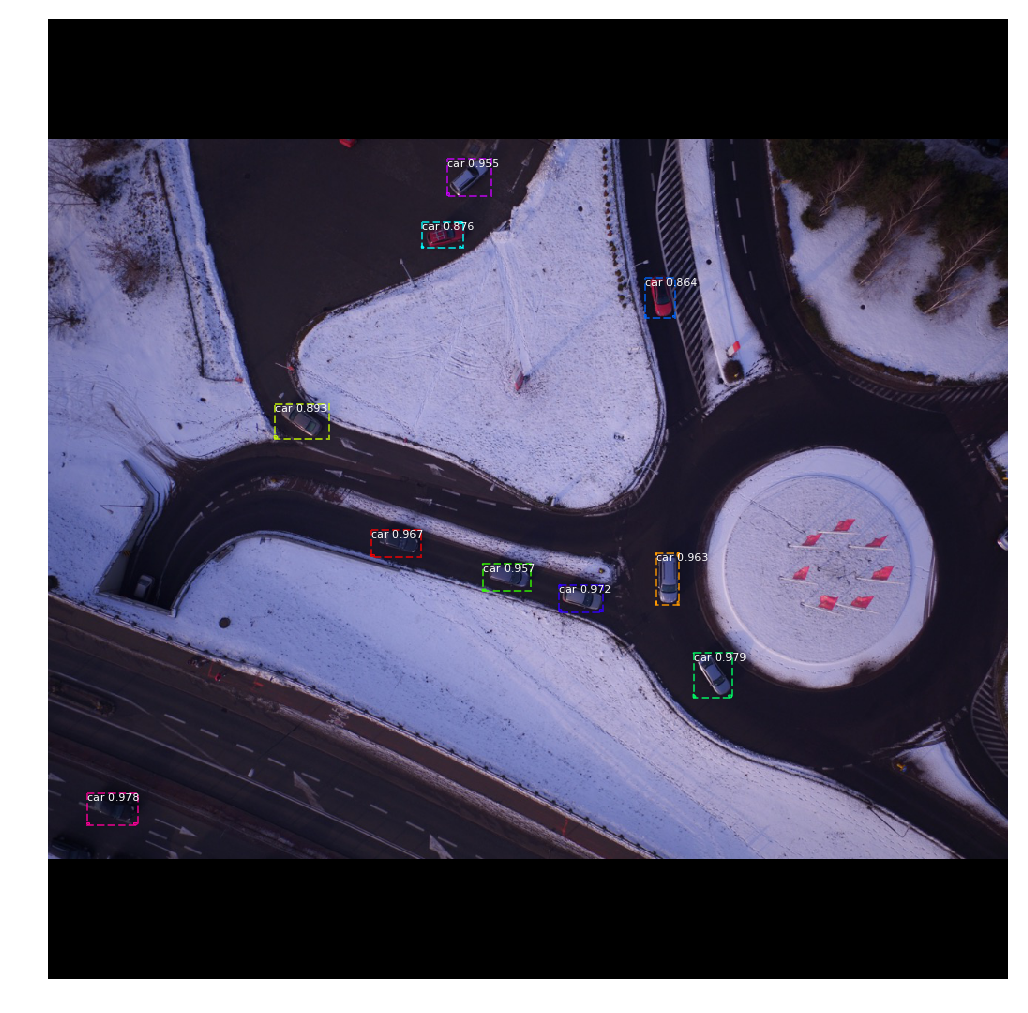

In [9]:
# Example prediction with loaded weights, which are loaded from .model_path file.
# Predictions can be visualized or not, depending on visualize_predictions setting.
# For predictions list of class_names should be provided, which correspond to configuration set in GISSConfig.

mrcnn_checkpoints_filename = 'logs/giss_depth020180501T1341/mask_rcnn_giss_depth0_0005.h5'  # Prediction weights filename, should be specified by hand at this point.

class_names = ['BG', 'car', 'building', 'human', 'truck', 'container', 'winter_car']
api_training.model_path = mrcnn_checkpoints_filename
mrcnn_model_trained = api_training.load_model(inference_config)


if mode == 'train':
    image = dataset_val.image_info[0]['image']
if mode == 'test':
    image = dataset_test.image_info[0]['image']

img_preds = api_training.predict_image(image, mrcnn_model_trained, class_names, 
                                       visualize_predictions=True)